<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/main/classification_ML_methods.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

https://habr.com/ru/articles/798331/

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from mlxtend.plotting import plot_decision_regions

In [ ]:
class GaussianNaiveBayes:
    def fit(self, X, y):
        classes, cls_counts = np.unique(y, return_counts=True)
        n_classes = len(classes)
        self.priors = cls_counts / len(y)

        # calculate the mean and standard deviations of features by classes
        self.X_cls_mean = np.array([np.mean(X[y == c], axis=0) for c in range(n_classes)])
        self.X_stds = np.array([np.std(X[y == c], axis=0) for c in range(n_classes)])

    # calculate the probability density of the feature according to the Gaussian distribution
    def pdf(self, x, mean, std):
        return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)

    def predict(self, X):
        pdfs = np.array([self.pdf(x, self.X_cls_mean, self.X_stds) for x in X])
        posteriors = self.priors * np.prod(pdfs, axis=2)   # shorten Bayes formula

        return np.argmax(posteriors, axis=1)

In [ ]:
# Scatter and density plots
def plotScatterMatrix(df, plotSize, textSize):
    df = df.select_dtypes(include =[np.number]) # keep only numerical columns
    # Remove rows and columns that would lead to df being singular
    df = df.dropna(axis='columns')
    df = df[[col for col in df if df[col].nunique() > 1]] # keep columns where there are more than 1 unique values
    columnNames = list(df)
    if len(columnNames) > 10: # reduce the number of columns for matrix inversion of kernel density plots
        columnNames = columnNames[:10]
    df = df[columnNames]
    ax = pd.plotting.scatter_matrix(df, alpha=0.75, figsize=[plotSize, plotSize], diagonal='hist')
    corrs = df.corr().values
    for i, j in zip(*plt.np.triu_indices_from(ax, k = 1)):
        ax[i, j].annotate('%.1f' % corrs[i, j], (0.8, 0.2), xycoords='axes fraction', ha='center', va='center', size=textSize)
    plt.suptitle('Таблица анализа данных, коэффициент корреляции')
    plt.show()

In [ ]:
def decision_boundary_plot(X, y, X_train, y_train, clf, feature_indexes, title=None):
    feature1_name, feature2_name = X.columns[feature_indexes]
    X_feature_columns = X.values[:, feature_indexes]
    X_train_feature_columns = X_train[:, feature_indexes]
    clf.fit(X_train_feature_columns, y_train)

    plot_decision_regions(X=X_feature_columns, y=y.values, clf=clf)
    plt.xlabel(feature1_name)
    plt.ylabel(feature2_name)
    plt.title(title)

# Загрузка, очистка и визуализация данных

Независимые переменные:
— возраст заемщика (age);
— образование заемщика (ed);
— стаж заемщика на последнем месте работы (employ);
— срок проживания заемщика по последнему адресу (address);
— ежемесячный личный доход заемщика (income);
— процент долговых обязательств заемщика от дохода (debtinc);
— долг заемщика по кредитной карте банка (creddebt);
— прочие долговые обязательства заемщика (othdebt).

In [ ]:
#table_data = pd.read_csv('bankloans.csv')
#table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/bankloans.csv')
table_data = pd.read_csv('https://raw.githubusercontent.com/TAUforPython/BioMedAI/main/test_datasets/test_data_ECG.csv', nrows=1000)
print(table_data)

     subject_id  Count_subj  study_id  cart_id  Healthy_Status eeg_time   \
0      19557662          27  40000017  6848296               0   8:44 AM   
1      18477137          93  40000029  6848296               0   9:54 AM   
2      16598616           3  40000035  6376932               1   9:07 AM   
3      16368287           7  40000079  6214760               1   5:14 PM   
4      18370366           2  40000084  6632385               0   1:52 PM   
..          ...         ...       ...      ...             ...       ...   
995    13962952           9  40012967  6826700               0  12:29 PM   
996    19461575          44  40012968  6868936               0   9:31 AM   
997    15420344           6  40012974  6376932               0   8:23 AM   
998    16233087          21  40012982  6903271               0  12:40 PM   
999    11340417           1  40012987  6848296               0   3:56 PM   

      eeg_date                   report_0  \
0    27.06.2015              Sinus rhythm 

In [ ]:
# make new dataset from old columns
table_data = table_data[['Healthy_Status', 'rr_interval','p_onset','p_end','qrs_onset','qrs_end','p_axis','qrs_axis']].copy()


In [ ]:
table_data = table_data.dropna(subset=['default'])
print(table_data)

In [ ]:
table_data['default'] = table_data['default'].astype('int')
print(table_data)

<Axes: ylabel='qrs_axis'>

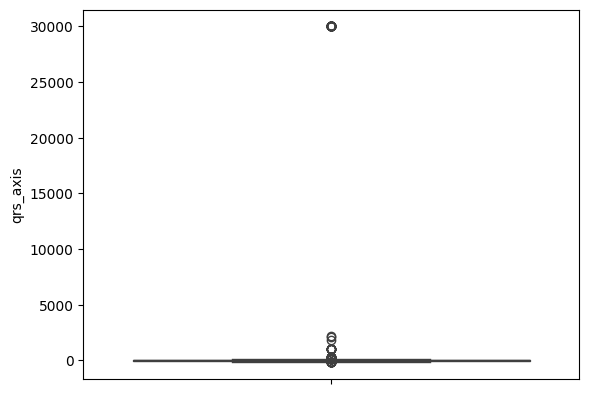

In [ ]:
sns.boxplot(y = table_data.iloc[:,7],data=table_data)

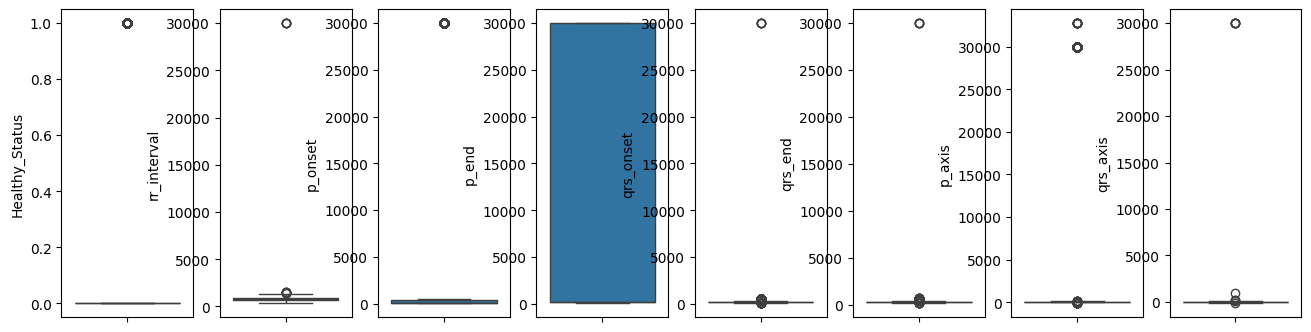

In [ ]:
n = table_data.shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    col = table_data.columns[i]
    sns.boxplot(y = table_data.iloc[:,i],data=table_data)

In [ ]:
# удаляем аномалии из данных (убрать все значения более 5000)
#table_data = table_data.drop(table_data[table_data['qrs_axis'] > 5000].index)
for i, v in enumerate(table_data):
  table_data = table_data.drop(table_data[table_data.iloc[:,i] > 10000].index)

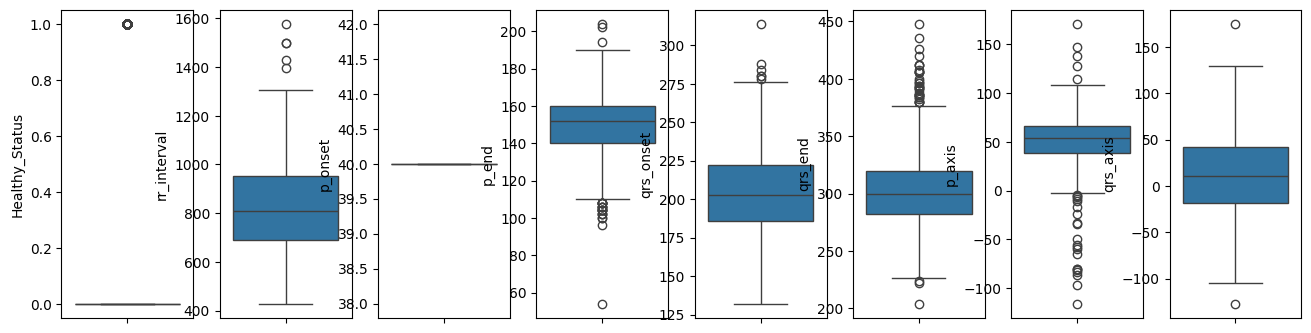

In [ ]:
n = table_data.shape[1]
fig,ax = plt.subplots(1,n, figsize=(n*2,4), sharex=True)
for i in range(n):
    plt.sca(ax[i])
    col = table_data.columns[i]
    sns.boxplot(y = table_data.iloc[:,i],data=table_data)
    plt.tight_layout

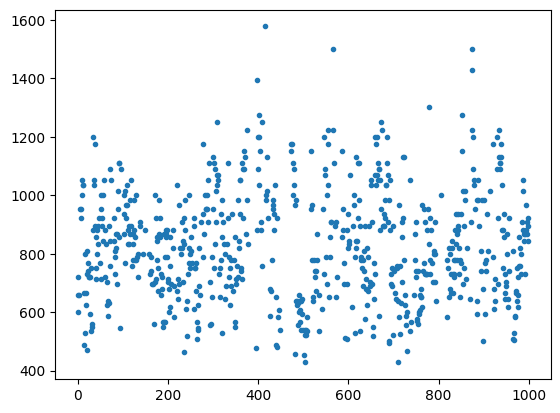

In [ ]:
plt.plot(table_data['rr_interval'],'.')


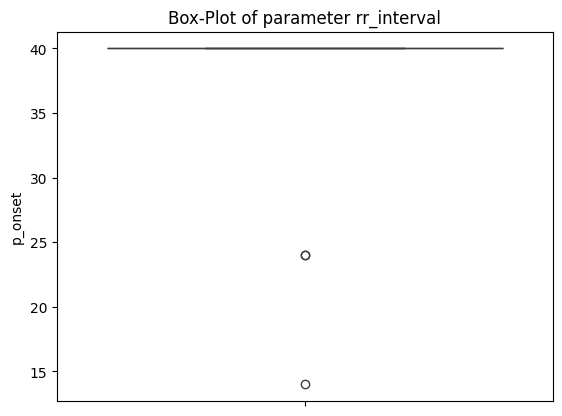

In [ ]:
#sns.boxplot(y = "age",data=table_data)
sns.boxplot(y = "p_onset",data=table_data)
plt.title("Box-Plot of parameter rr_interval")
plt.show()

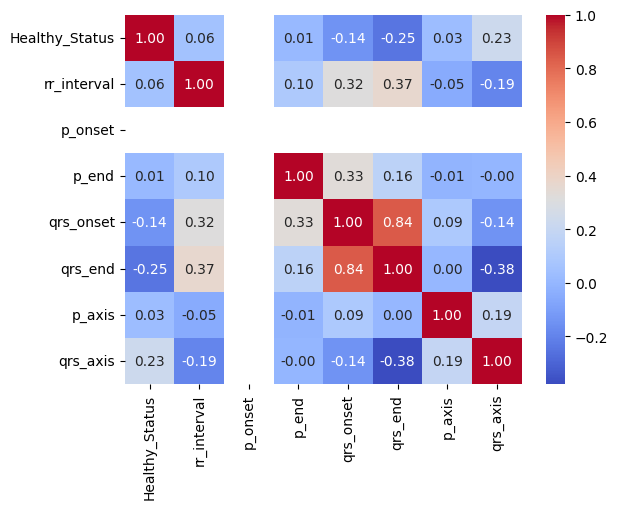

In [ ]:
sns.heatmap(table_data.corr(),annot=True,fmt="0.2f",cmap="coolwarm")
plt.show()

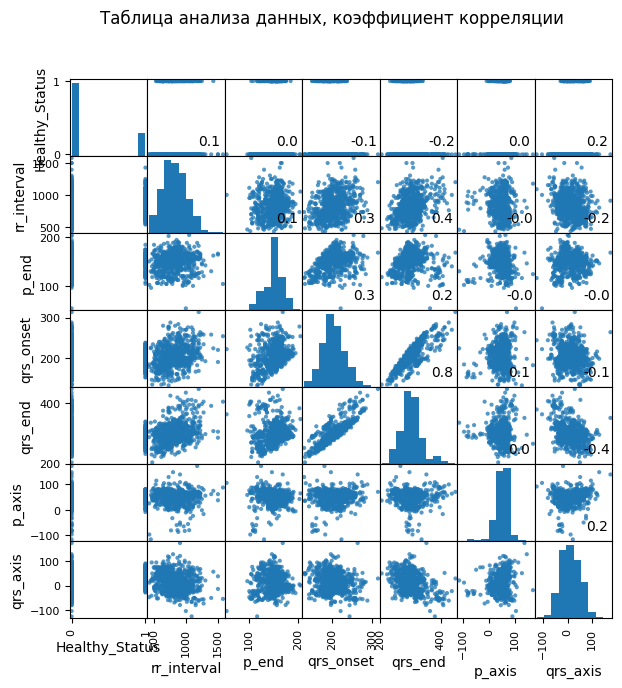

In [ ]:
plotScatterMatrix(table_data, 7, 10)

<Axes: xlabel='rr_interval', ylabel='p_axis'>

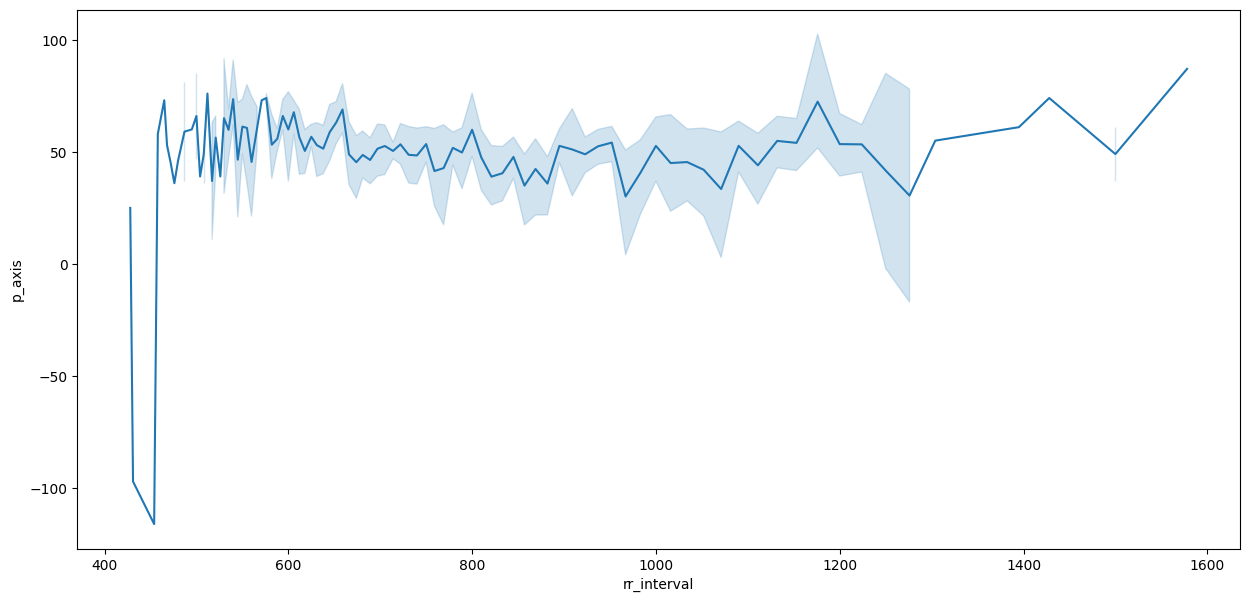

In [ ]:
fig,ax = plt.subplots(figsize=(15,7))
#sns.lineplot(x='age',y='debtinc',data=table_data,ax=ax)
sns.lineplot(x='rr_interval',y='p_axis',data=table_data,ax=ax)

# ML-классификация: модель GaussianNaiveBayes

In [ ]:
#So, when you do [:, -1] it means you are taking all the rows and only the last column. -1 represents the last column.
#When you do [:, :-1], it means you are taking all the rows and all the columns except the last column.
#X1, y1 = table_data.iloc[:, :-1], table_data.iloc[:, -1]

In [ ]:
# set the classification index of table
clf_index = 0

# classification variable
y1 = table_data.iloc[:, clf_index]
# input variable
X1 = table_data.drop(table_data.columns[[clf_index]], axis=1).iloc[:,:]

y1 = pd.Series(LabelEncoder().fit_transform(y1))
X1_train, X1_test, y1_train, y1_test = train_test_split(X1.values,
                                                        y1.values,
                                                        test_size=0.3,
                                                        random_state=0,
                                                        stratify=y1.values)

In [ ]:
nb_clf = GaussianNaiveBayes()
nb_clf.fit(X1_train, y1_train)
nb_clf_pred_res = nb_clf.predict(X1_test)
nb_clf_accuracy = accuracy_score(y1_test, nb_clf_pred_res)

print(f'Naive Bayes classifier accucacy: {nb_clf_accuracy}')
print(nb_clf_pred_res)

Naive Bayes classifier accucacy: 0.29347198151357595
[1 1 1 ... 1 1 1]


<ipython-input-65-e61f33113988>:13: RuntimeWarning: divide by zero encountered in divide
  return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)
<ipython-input-65-e61f33113988>:13: RuntimeWarning: invalid value encountered in divide
  return (1 / (np.sqrt(2 * np.pi) * std)) * np.exp(-0.5 * ((x - mean) / std) ** 2)


sk Naive Bayes classifier accucacy: 0.4119006354708261
[1 0 0 ... 1 1 1]


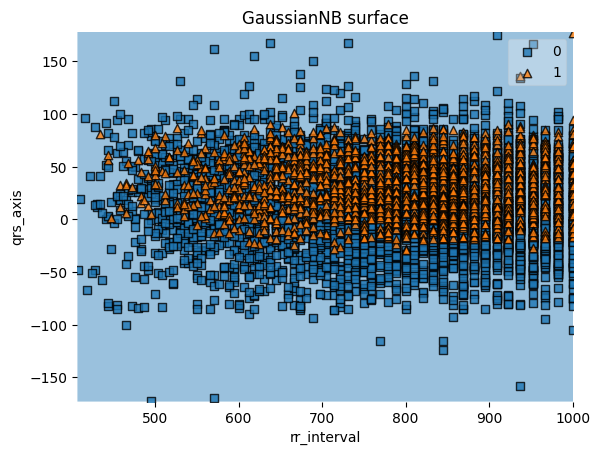

In [ ]:
sk_nb_clf = GaussianNB()
sk_nb_clf.fit(X1_train, y1_train)
sk_nb_clf_pred_res = sk_nb_clf.predict(X1_test)
sk_nb_clf_accuracy = accuracy_score(y1_test, sk_nb_clf_pred_res)

print(f'sk Naive Bayes classifier accucacy: {sk_nb_clf_accuracy}')
print(sk_nb_clf_pred_res)

feature_indexes = [0, 6]
title1 = 'GaussianNB surface'
decision_boundary_plot(X1, y1, X1_train, y1_train, sk_nb_clf, feature_indexes, title1)

# ML - Описание классов и матрица ошибок

In [ ]:
from sklearn import metrics
from sklearn.metrics import classification_report,confusion_matrix

In [ ]:
table_data.columns

Index(['Healthy_Status', 'rr_interval', 'p_onset', 'p_end', 'qrs_onset',
       'qrs_end', 'p_axis', 'qrs_axis'],
      dtype='object')

In [ ]:
# set the classification index of table
clf_index = 0

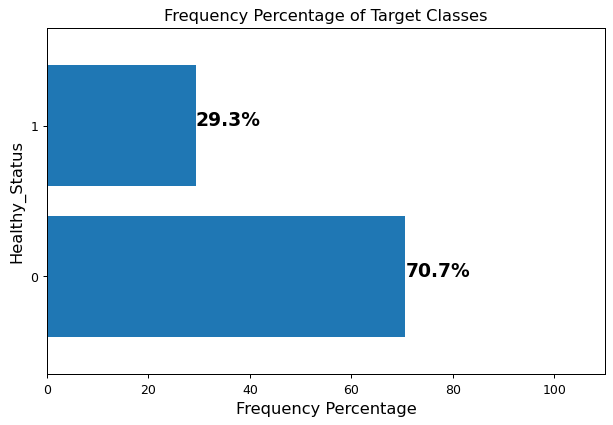

In [ ]:
plt.figure(figsize=(35,20),dpi=90)
# Plot frequency percentages barplot
table_data[table_data.columns[clf_index]].value_counts(normalize=True).mul(100).plot(kind='barh', width=0.8, figsize=(8,5))

# Add frequency percentages to the plot
labels = table_data[table_data.columns[clf_index]].value_counts(normalize=True).mul(100).round(1)
for i in labels.index:
    plt.text(labels[i], i, str(labels[i])+ '%', fontsize=15, weight='bold')

plt.xlim([0, 110])
plt.xlabel('Frequency Percentage', fontsize=13)
plt.ylabel(table_data.columns[clf_index], fontsize=13)
plt.title('Frequency Percentage of Target Classes', fontsize=13)
plt.show()

In [ ]:
# set the classification index of table
clf_index = 0

# classification variable
y1 = table_data.iloc[:, clf_index]
# input variable
X1 = table_data.drop(table_data.columns[[clf_index]], axis=1).iloc[:,:]

y1 = pd.Series(LabelEncoder().fit_transform(y1))
X1_train, X1_test, y1_train, y1_test = train_test_split(X1.values,
                                                        y1.values,
                                                        test_size=0.3,
                                                        random_state=0,
                                                        stratify=y1.values)

In [ ]:
X_train,X_test,y_train,y_test = train_test_split(X1.values,
                                                 y1.values,
                                                 test_size=0.3,
                                                 random_state=41,
                                                 stratify=y1.values)
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

NameError: name 'X1' is not defined

In [ ]:
GussianClassifier = GaussianNB()
GussianClassifier.fit(X1_train,y1_train)
y_pred=GussianClassifier.predict(X_test)
print("===================================> Result <===================================")
print("Accuracy                     = " ,metrics.accuracy_score(y_test,y_pred))
print("F1 Score                     = " ,metrics.f1_score(y_test,y_pred))

===================================> Result <===================================
Accuracy                     =  0.41536683997689194
F1 Score                     =  0.499009900990099


In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay

              precision    recall  f1-score   support

        True       0.98      0.18      0.30      1223
       False       0.33      0.99      0.50       508

    accuracy                           0.42      1731
   macro avg       0.66      0.58      0.40      1731
weighted avg       0.79      0.42      0.36      1731



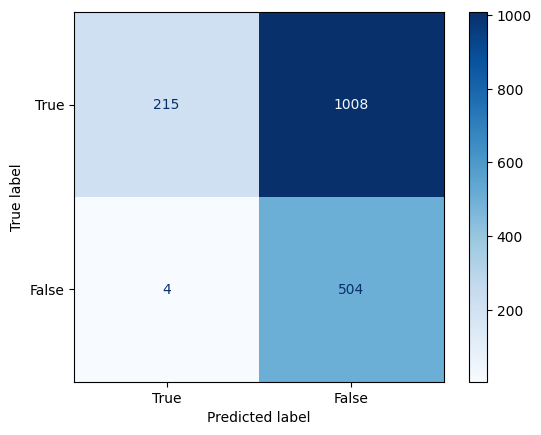

In [ ]:
target_names = ['True', 'False']
labels_names = [0,1]
print(classification_report(y_test, y_pred,labels=labels_names, target_names=target_names))
#cm = confusion_matrix(y_test, y_pred,labels=labels_names,normalize='true')
cm = confusion_matrix(y_test, y_pred,labels=labels_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=target_names)
disp = disp.plot(cmap=plt.cm.Blues,values_format='g')
plt.show()

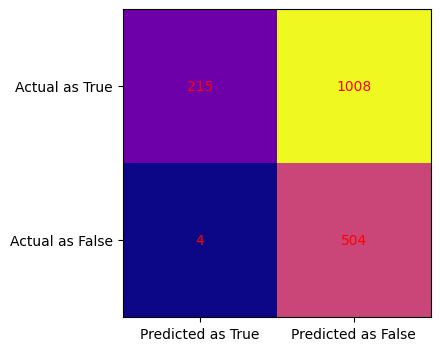

In [ ]:
cm = confusion_matrix(y_test,GussianClassifier.predict(X_test))

fig , ax  = plt.subplots(figsize=(4,4))
ax.imshow(cm, cmap = 'plasma')
ax.grid(False)
ax.xaxis.set(ticks=(0,1),ticklabels=("Predicted as True","Predicted as False"))
ax.yaxis.set(ticks=(0,1),ticklabels=("Actual as True","Actual as False"))
ax.set_ylim(1.5,-0.5)
for i in range(2):
    for j in range(2):
        ax.text(j,i,cm[i,j],ha="center",va="center",color = "red")

# Сравнение ML алгоритмов

In [ ]:
table_data.columns

Index(['Healthy_Status', 'rr_interval', 'p_onset', 'p_end', 'qrs_onset',
       'qrs_end', 'p_axis', 'qrs_axis'],
      dtype='object')

In [ ]:
clf_index = 0
feature_indexes = [4, 7]

table_data_clf = (table_data.values[:,feature_indexes],
                  table_data[table_data.columns[clf_index]])

In [ ]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

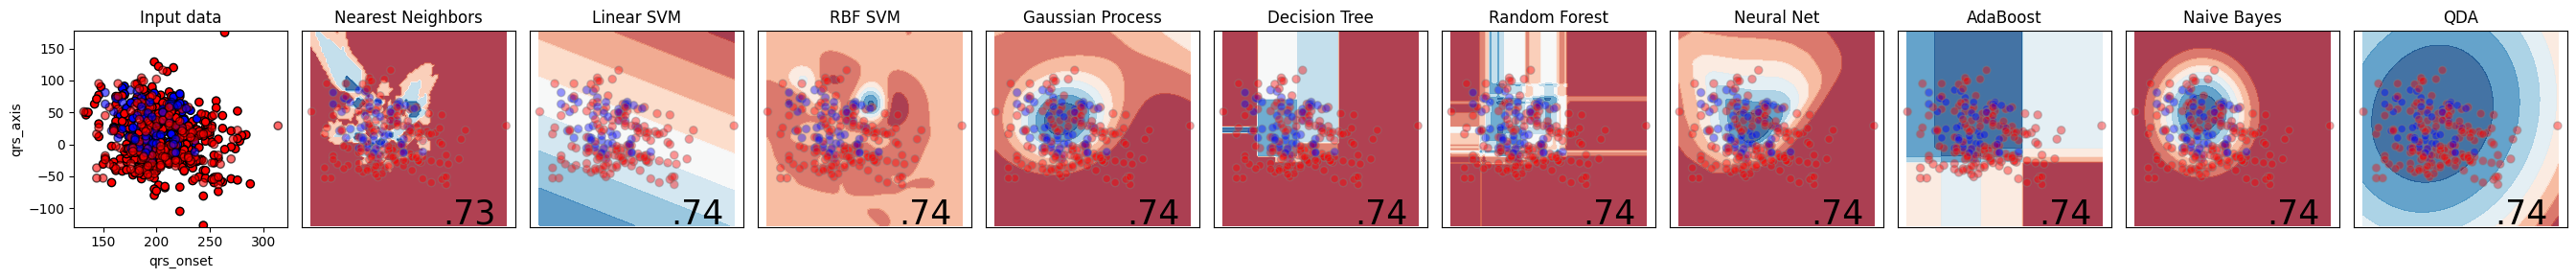

In [ ]:

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]


datasets = [
    #make_moons(noise=0.3, random_state=0),
    #make_circles(noise=0.2, factor=0.5, random_state=1),
    #linearly_separable,
    table_data_clf
]

figure = plt.figure(figsize=(27, 3))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42
    )

    #x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    #y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5
    x_range = abs(X[:, 0].max()) - abs(X[:, 0].min())
    y_range = abs(X[:, 1].max()) - abs(X[:, 1].min())

    x_min, x_max = X[:, 0].min() - 0.05*x_range, X[:, 0].max() + 0.05*x_range
    y_min, y_max = X[:, 1].min() - 0.05*y_range, X[:, 1].max() + 0.05*y_range


    # just plot the dataset first
    cm = plt.cm.RdBu
    # red and blue = 0000FF color. Red = 0. Blue = 1 status
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    #ax.set_xticks(())
    #ax.set_yticks(())
    ax.set_xlabel(table_data.columns[feature_indexes[0]])
    ax.set_ylabel(table_data.columns[feature_indexes[1]])
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        #ax.scatter(
        #    X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        #)
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="grey",
            alpha=0.4,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - x_range*0.1,
            y_min + y_range*0.1,
            ("%.2f" % score).lstrip("0"),
            size=25,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()

In [ ]:
datasets

[(array([[ 0, 81],
         [ 0, 77],
         [ 1, 79],
         ...,
         [ 1, 70],
         [ 1, 43],
         [ 0, 30]]),
  0       0
  1       0
  2       1
  3       1
  6       1
         ..
  9994    1
  9995    1
  9996    1
  9998    1
  9999    0
  Name: Healthy_Status, Length: 7046, dtype: int64)]

# Примеры классификаторов на модельных задачах

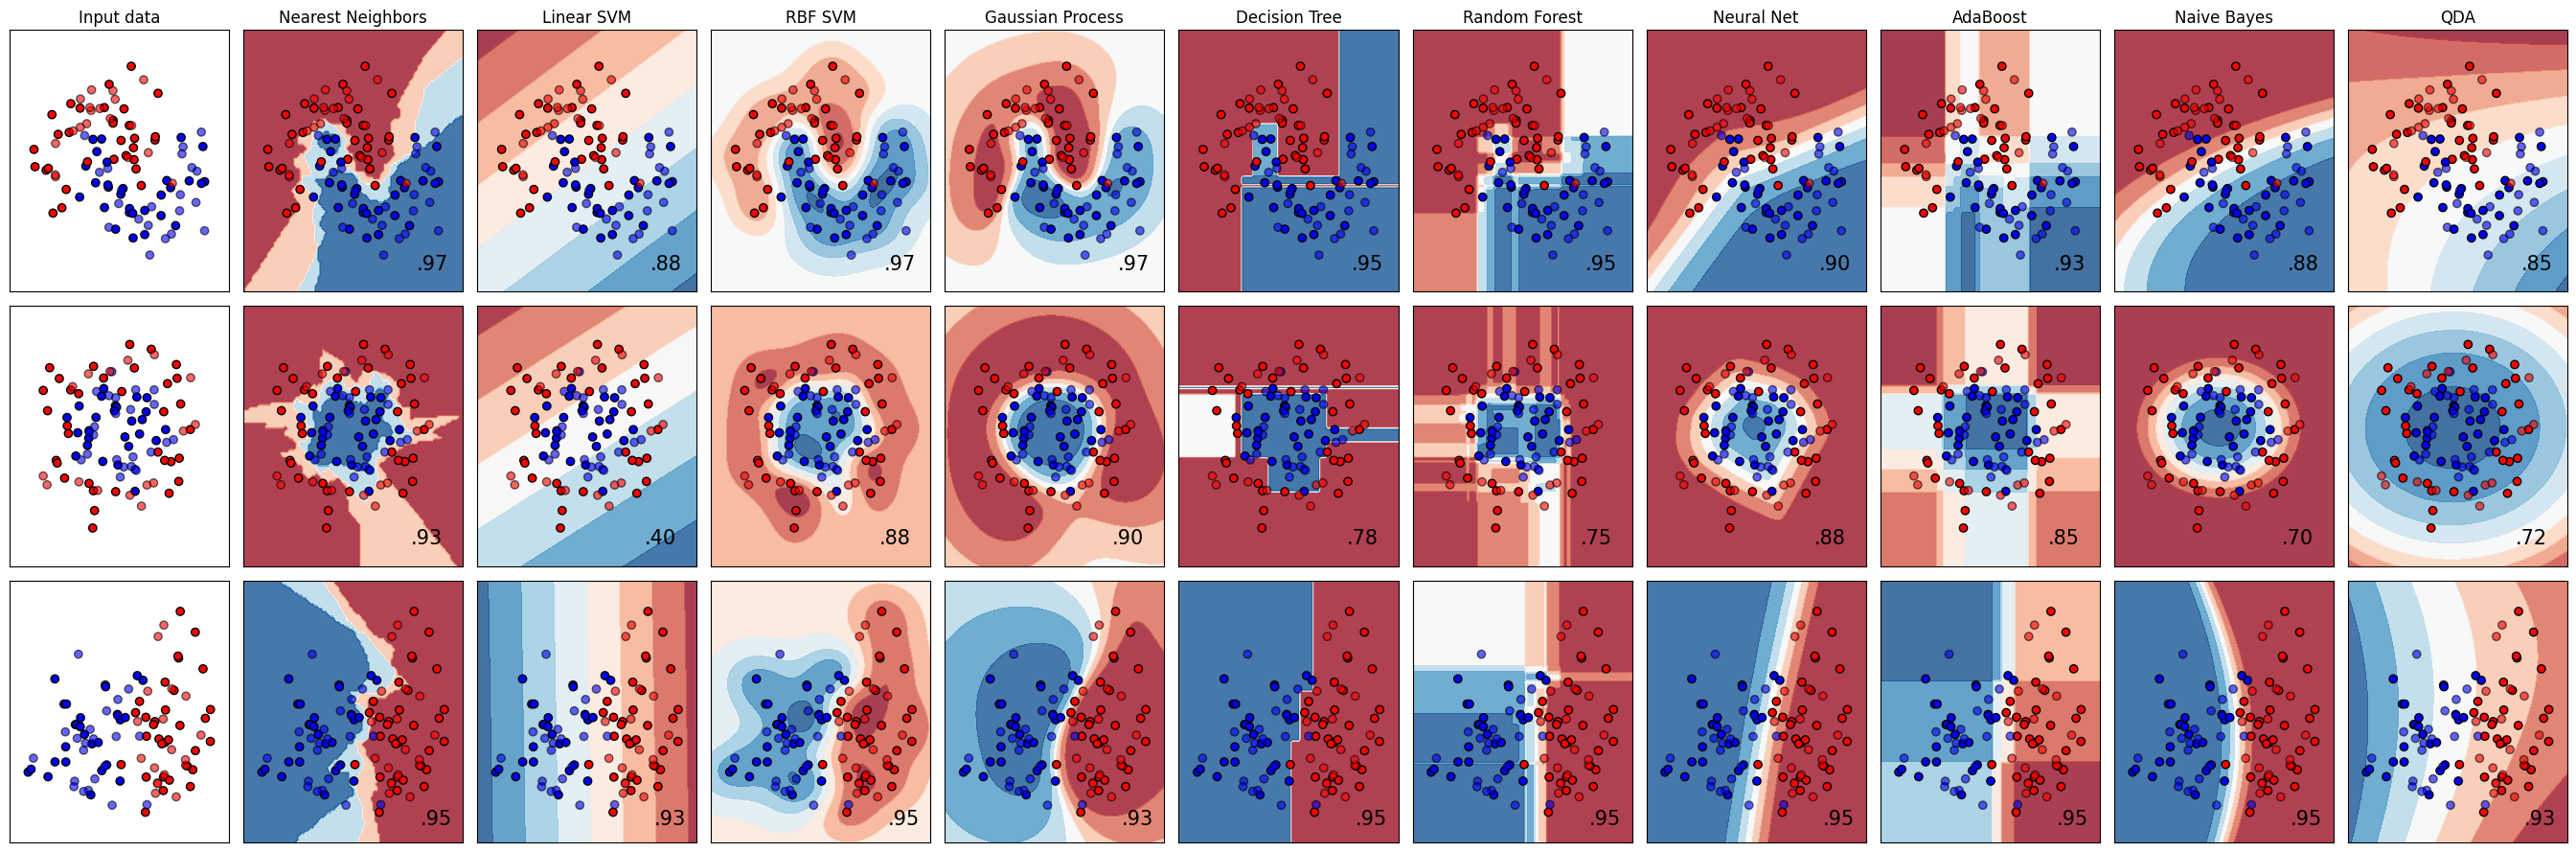

In [ ]:
# Code source: Gaël Varoquaux
#              Andreas Müller
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import matplotlib.pyplot as plt
import numpy as np
from matplotlib.colors import ListedColormap

from sklearn.datasets import make_circles, make_classification, make_moons
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.inspection import DecisionBoundaryDisplay
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier

names = [
    "Nearest Neighbors",
    "Linear SVM",
    "RBF SVM",
    "Gaussian Process",
    "Decision Tree",
    "Random Forest",
    "Neural Net",
    "AdaBoost",
    "Naive Bayes",
    "QDA",
]

classifiers = [
    KNeighborsClassifier(3),
    SVC(kernel="linear", C=0.025, random_state=42),
    SVC(gamma=2, C=1, random_state=42),
    GaussianProcessClassifier(1.0 * RBF(1.0), random_state=42),
    DecisionTreeClassifier(max_depth=5, random_state=42),
    RandomForestClassifier(
        max_depth=5, n_estimators=10, max_features=1, random_state=42
    ),
    MLPClassifier(alpha=1, max_iter=1000, random_state=42),
    AdaBoostClassifier(algorithm="SAMME", random_state=42),
    GaussianNB(),
    QuadraticDiscriminantAnalysis(),
]

X, y = make_classification(
    n_features=2, n_redundant=0, n_informative=2, random_state=1, n_clusters_per_class=1
)
rng = np.random.RandomState(2)
X += 2 * rng.uniform(size=X.shape)
linearly_separable = (X, y)

datasets = [
    make_moons(noise=0.3, random_state=0),
    make_circles(noise=0.2, factor=0.5, random_state=1),
    linearly_separable,
]

figure = plt.figure(figsize=(27, 9))
i = 1
# iterate over datasets
for ds_cnt, ds in enumerate(datasets):
    # preprocess dataset, split into training and test part
    X, y = ds
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.4, random_state=42
    )

    x_min, x_max = X[:, 0].min() - 0.5, X[:, 0].max() + 0.5
    y_min, y_max = X[:, 1].min() - 0.5, X[:, 1].max() + 0.5

    # just plot the dataset first
    cm = plt.cm.RdBu
    # red and blue = 0000FF color. Red = 0, Blue = 1 status
    cm_bright = ListedColormap(["#FF0000", "#0000FF"])
    ax = plt.subplot(len(datasets), len(classifiers) + 1, i)
    if ds_cnt == 0:
        ax.set_title("Input data")
    # Plot the training points
    ax.scatter(X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k")
    # Plot the testing points
    ax.scatter(
        X_test[:, 0], X_test[:, 1], c=y_test, cmap=cm_bright, alpha=0.6, edgecolors="k"
    )
    ax.set_xlim(x_min, x_max)
    ax.set_ylim(y_min, y_max)
    ax.set_xticks(())
    ax.set_yticks(())
    i += 1

    # iterate over classifiers
    for name, clf in zip(names, classifiers):
        ax = plt.subplot(len(datasets), len(classifiers) + 1, i)

        clf = make_pipeline(StandardScaler(), clf)
        clf.fit(X_train, y_train)
        score = clf.score(X_test, y_test)
        DecisionBoundaryDisplay.from_estimator(
            clf, X, cmap=cm, alpha=0.8, ax=ax, eps=0.5
        )

        # Plot the training points
        ax.scatter(
            X_train[:, 0], X_train[:, 1], c=y_train, cmap=cm_bright, edgecolors="k"
        )
        # Plot the testing points
        ax.scatter(
            X_test[:, 0],
            X_test[:, 1],
            c=y_test,
            cmap=cm_bright,
            edgecolors="k",
            alpha=0.6,
        )

        ax.set_xlim(x_min, x_max)
        ax.set_ylim(y_min, y_max)
        ax.set_xticks(())
        ax.set_yticks(())
        if ds_cnt == 0:
            ax.set_title(name)
        ax.text(
            x_max - 0.3,
            y_min + 0.3,
            ("%.2f" % score).lstrip("0"),
            size=15,
            horizontalalignment="right",
        )
        i += 1

plt.tight_layout()
plt.show()